In [1]:
!pip install --quiet git+https://github.com/boudinfl/pke.git
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 21.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
import pandas as pd
import numpy as np
import pke
from pke.unsupervised import *
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import traceback
import unidecode
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
dataset_file = "Scielo Brasil Dataset.csv"
dataset_df = pd.read_csv(dataset_file)

dataset_df

,Termo,Título,Resumo,Palavras-chave,URL artigo
0,educação à distância,DOCÊNCIA NA EDUCAÇÃO À DISTÂNCIA: PROCESSOS DE...,O presente estudo foi produzido para conhecer ...,subjetividade; trabalho docente; mídia,https://www.scielo.br/j/pee/a/wx75hKgC4HHrVtgv...
1,educação à distância,ENSINO REMOTO PARA ESTUDANTES DO PÚBLICO-ALVO ...,Em decorrência da pandemia da Covid-19 e das m...,inclusão escolar; covid-19; planejamento educa...,https://www.scielo.br/j/edur/a/HVbpYScg5kWBDg4...
2,educação à distância,INSTITUCIONALIZAÇÃO DA EDUCAÇÃO A DISTÂNCIA PÚ...,O objetivo deste artigo é examinar as relações...,educação a distância; institucionalização; Sis...,https://www.scielo.br/j/edur/a/rZrHFb9Dz4SJqTN...
3,educação à distância,O ENSINO REMOTO DE EDUCAÇÃO FÍSICA EM NARRATIV...,A literatura tem apostado na compreensão coevo...,Educação Física; Covid-19; Educação a distânci...,https://www.scielo.br/j/mov/a/zwjhPff8QG3cFgQ8...
4,educação à distância,APRENDIZAGEM VIRTUAL: UM AUTOESTUDO SOBRE EVOL...,Este artigo relata a primeira fase de um proje...,Educação a distância; Educação superior; covid...,https://www.scielo.br/j/mov/a/YhQNtPR57hw7Swsd...
...,...,...,...,...,...
192,mobile learning,Time Trails: apresentando a herança digital em...,O projeto Time Trails é uma colaboração entre ...,Presença; Patrimônio Digital; Realidade Mista;...,https://www.scielo.br/j/rbep/a/bSWnQBGxvQMZ3XP...
193,mobile learning,Melhorar a atratividade da informação através ...,Propomo-nos neste trabalho abordar o conceito ...,Realidade aumentada; Aprendizagem autónoma; M-...,https://www.scielo.br/j/pci/a/DgkwT3B3CzBDQpfW...
194,mobile learning,Estado de Mobile Learning na Espanha,As tecnologias móveis tornaram-se dispositivos...,mobile learning; e-learning; produção científi...,https://www.scielo.br/j/er/a/49X4Hzq7Zkbc7FNpn...
195,mobile learning,Aplicativo multimídia em plataforma móvel para...,O objetivo do estudo foi desenvolver e avaliar...,Pressão venosa central; Ensino; Aprendizagem; ...,https://www.scielo.br/j/reeusp/a/L5Qpz6TtgtW7F...


## Functions

In [4]:
def preprocess_text(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  tokenizer = RegexpTokenizer(r'\w+')
  words = tokenizer.tokenize(text)

  text= ""
  for word in words:
      text = text + word + " "

  return text

def preprocess_target_keywords(target_keywords):
  text = target_keywords.lower()
  text = unidecode.unidecode(text)
  keywords = [keyword.strip() for keyword in text.split(";")]

  return keywords

def get_keywords(text, model):
  out=[]
  try:
    stoplist = list(string.punctuation)
    stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
    stoplist += stopwords.words('portuguese')
    extractor = model()
    extractor.load_document(input=text, language='pt', stoplist=stoplist)
    extractor.candidate_selection()
    extractor.candidate_weighting()
    keyphrases = extractor.get_n_best(n=20)
    
    for val in keyphrases:
        out.append(val[0])
  except:
    out = []
    traceback.print_exc()

  return out

In [5]:
def precision_at_k(k, predicted_keywords, target_keywords):
  predicted_keywords_at_k = predicted_keywords[:k]
  relevant_predictions_count = len(set(predicted_keywords_at_k).intersection(target_keywords))

  return relevant_predictions_count/k

def recall_at_k(k, predicted_keywords, target_keywords):
  predicted_keywords_at_k = predicted_keywords[:k]
  relevant_predictions_count = len(set(predicted_keywords_at_k).intersection(target_keywords))

  return relevant_predictions_count/len(target_keywords)

def f1_at_k(precision_at_k, recall_at_k):
  f1 = 0

  if (precision_at_k + recall_at_k) > 0:
    f1 = 2 * precision_at_k * recall_at_k / (precision_at_k + recall_at_k)

  return f1

def reciprocal_rank_at_k(k, predicted_keywords, target_keywords):
  predicted_keywords_at_k = predicted_keywords[:k]
  rank_of_first_relevant_keyword = 0
  reciprocal_rank = 0

  for index, predicted_keyword in enumerate(predicted_keywords_at_k):
    if predicted_keyword in target_keywords:
      rank_of_first_relevant_keyword = index + 1
      break
  
  if rank_of_first_relevant_keyword > 0:
    reciprocal_rank= 1/rank_of_first_relevant_keyword
  
  return reciprocal_rank

## Experiments

In [6]:
dataset_df["input_text"] = dataset_df["Título"] + " " + dataset_df["Resumo"]
input_text_processed = dataset_df["input_text"].apply(preprocess_text).values
target_keywords_processed = dataset_df["Palavras-chave"].apply(preprocess_target_keywords).values

In [18]:
ks = [1,2,3,4,5,6,7,8,9,10]

models = [FirstPhrases, YAKE, TextRank, SingleRank, TopicRank, PositionRank, MultipartiteRank]
# models = [YAKE, SingleRank]
models_evaluations = {}

for model in models:
  print("===========")
  print(f"Model: {model.__name__}")

  precisions = []
  recalls = []
  f1s = []
  reciprocal_ranks = []
  models_evaluations[model.__name__] = {}

  for index, text in enumerate(input_text_processed):
    print(f"Getting keywords from text index {index}...")
    predicted_keywords = get_keywords(text, model)
    target_keywords = target_keywords_processed[index]
    
    
    precisions_at_ks = []
    recalls_at_ks = []
    f1_at_ks = []
    reciprocal_ranks_at_ks = []
    for k in ks:
      precision = precision_at_k(k, predicted_keywords, target_keywords)
      recall = recall_at_k(k, predicted_keywords, target_keywords)
      f1 = f1_at_k(precision, recall)
      reciprocal_rank = reciprocal_rank_at_k(k, predicted_keywords, target_keywords)

      precisions_at_ks.append(precision)
      recalls_at_ks.append(recall)
      f1_at_ks.append(f1)
      reciprocal_ranks_at_ks.append(reciprocal_rank)

    precisions.append(precisions_at_ks)
    recalls.append(recalls_at_ks)
    f1s.append(f1_at_ks)
    reciprocal_ranks.append(reciprocal_ranks_at_ks)

  models_evaluations[model.__name__]["precision_at_k_means"] = np.mean(np.array(precisions), axis=0)
  models_evaluations[model.__name__]["recall_at_k_means"] = np.mean(np.array(recalls), axis=0)
  models_evaluations[model.__name__]["f1_at_k_means"] = np.mean(np.array(f1s), axis=0)
  models_evaluations[model.__name__]["mean_reciprocal_rank_at_ks"] = np.mean(np.array(reciprocal_ranks), axis=0)

Model: FirstPhrases
Getting keywords from text index 0...
Getting keywords from text index 1...
Getting keywords from text index 2...
Getting keywords from text index 3...
Getting keywords from text index 4...
Getting keywords from text index 5...
Getting keywords from text index 6...
Getting keywords from text index 7...
Getting keywords from text index 8...
Getting keywords from text index 9...
Getting keywords from text index 10...
Getting keywords from text index 11...
Getting keywords from text index 12...
Getting keywords from text index 13...
Getting keywords from text index 14...
Getting keywords from text index 15...
Getting keywords from text index 16...
Getting keywords from text index 17...
Getting keywords from text index 18...
Getting keywords from text index 19...
Getting keywords from text index 20...
Getting keywords from text index 21...
Getting keywords from text index 22...
Getting keywords from text index 23...
Getting keywords from text index 24...
Getting keyword

## Results

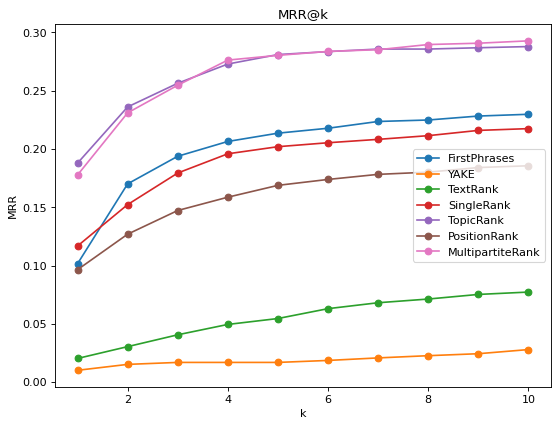

In [43]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("MRR@k")
plt.xlabel("k")
plt.ylabel("MRR")

for model in models_evaluations.keys():
  plt.plot(ks, models_evaluations[model]["mean_reciprocal_rank_at_ks"], "o-")

plt.legend(models_evaluations.keys())
plt.show()

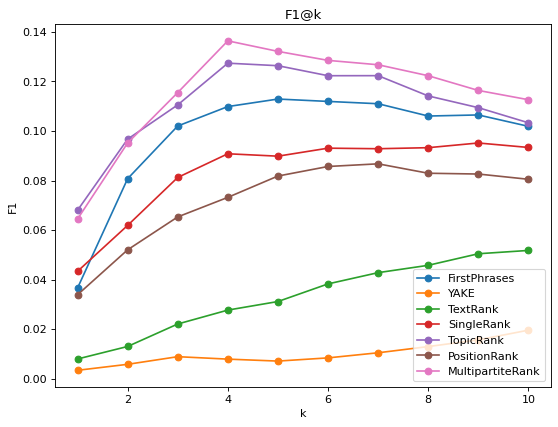

In [45]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("F1@k")
plt.xlabel("k")
plt.ylabel("F1")

for model in models_evaluations.keys():
  plt.plot(ks, models_evaluations[model]["f1_at_k_means"], "o-")

plt.legend(models_evaluations.keys())
plt.show()

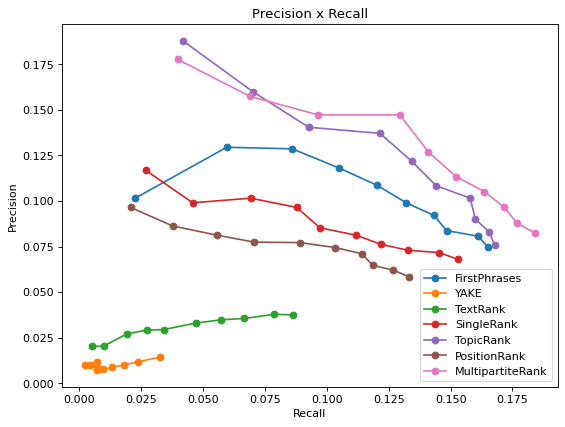

In [46]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Precision x Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

for model in models_evaluations.keys():
  plt.plot(models_evaluations[model]["recall_at_k_means"], models_evaluations[model]["precision_at_k_means"], "o-")

plt.legend(models_evaluations.keys())
plt.show()

In [41]:
# Precision, Recall, F1 and MRR table

models_evaluations_data = []
top_ks = [2,4,6,8]
columns = []

for k in top_ks:
  columns.append(f"p_{k}")
  columns.append(f"r_{k}")
  columns.append(f"f1_{k}")
  columns.append(f"mrr_{k}")

for model in models_evaluations.keys():
  model_evaluations_data = []
  for k in top_ks:
    model_evaluations_data.append(models_evaluations[model]["precision_at_k_means"][k])
    model_evaluations_data.append(models_evaluations[model]["recall_at_k_means"][k])
    model_evaluations_data.append(models_evaluations[model]["f1_at_k_means"][k])
    model_evaluations_data.append(models_evaluations[model]["mean_reciprocal_rank_at_ks"][k])

  models_evaluations_data.append(model_evaluations_data)

models_evaluations_data = np.around(np.array(models_evaluations_data) * 100, decimals=1)
models_evaluations_df = pd.DataFrame(index=list(models_evaluations.keys()), data=models_evaluations_data, columns=columns)
models_evaluations_df.to_csv("models_evaluations.csv")
models_evaluations_df

,p_2,r_2,f1_2,mrr_2,p_4,r_4,f1_4,mrr_4,p_6,r_6,f1_6,mrr_6,p_8,r_8,f1_8,mrr_8
FirstPhrases,12.9,8.6,10.2,19.4,10.9,12.0,11.3,21.4,9.2,14.3,11.1,22.4,8.1,16.1,10.6,22.8
YAKE,1.2,0.7,0.9,1.7,0.7,0.7,0.7,1.7,0.9,1.3,1.0,2.1,1.2,2.4,1.6,2.4
TextRank,2.7,1.9,2.2,4.1,2.9,3.4,3.1,5.5,3.5,5.7,4.3,6.8,3.8,7.9,5.0,7.5
SingleRank,10.2,6.9,8.1,17.9,8.5,9.7,9.0,20.2,7.6,12.2,9.3,20.8,7.2,14.5,9.5,21.6
TopicRank,14.0,9.3,11.1,25.6,12.2,13.4,12.6,28.1,10.2,15.8,12.2,28.6,8.3,16.6,10.9,28.7
PositionRank,8.1,5.6,6.5,14.7,7.7,8.9,8.2,16.9,7.1,11.4,8.7,17.8,6.2,12.7,8.3,18.4
MultipartiteRank,14.7,9.7,11.5,25.5,12.7,14.1,13.2,28.0,10.5,16.4,12.7,28.5,8.8,17.7,11.6,29.1
